In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x

In [3]:
def Diffusion_Coeff(c):
  # constants
  D_ref = 2e-16
  c_max = 4.665e4
  C_theory = 277.84
  C_practical = 160

  # equations
  SOC = (c_max - c)/c_max * C_theory/C_practical
  D = D_ref * (1 + 100*SOC**(3/2))

  return D

tensor([[0.0025]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0238]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0344]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0392]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0413]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0424]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0430]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0432]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0434]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0435]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0435]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0435]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0435]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0435]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0436]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0436]], device='cuda:0', grad_fn=<AddmmBackw

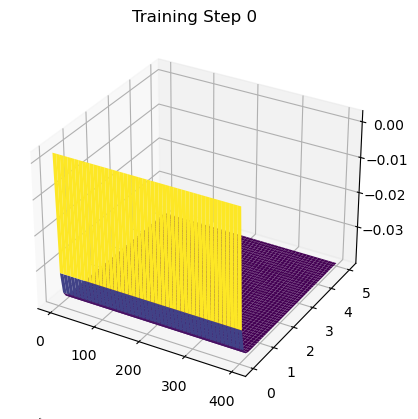

tensor([[0.0022]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0223]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0317]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0360]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0380]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0390]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0395]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0397]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0398]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0399]], device='cuda:0', grad_fn=<AddmmBackw

KeyboardInterrupt: 

In [29]:
# nn seed


# define nn to train, two inputs for x and t
pinn = Network(2, 5, 20, 1).to(device)

# parameters and things
Rs = 5e-6
j = -5.35e-5
C0 = 2e4
Cm = 4.665e4

# x and t boundary points for training x boundaries, x = 0,1, varying t values
r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
rs_boundary = torch.tensor(Rs).view(-1, 1).requires_grad_(True).to(device)
t_boundaries = torch.linspace(0, 400, 100).view(-1, 1).requires_grad_(True).to(device)

# 0 time boundary for training
t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
r_boundary = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)


# training things
epochs = 30000
lr = 1e-3
lambda_r0= 1
lambda_Rs = 1
lambda_t = 1
lambda_phys = 1

# optimiser
optimiser = torch.optim.Adam(pinn.parameters(), lr = lr)
losses = []

for e in range(epochs):

  optimiser.zero_grad()

  # x, t for phsyics loss
  r_physics = 5e-6 * torch.rand(100).requires_grad_(True).to(device)
  t_physics = 400 * torch.rand(100).requires_grad_(True).to(device)

  # r0 boundary loss
  outputs = torch.empty(0).to(device)
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(r0_boundary, t)
    c_r = torch.autograd.grad(c, r0_boundary, torch.ones_like(r0_boundary), create_graph = True)[0]
    outputs = torch.cat([outputs, c_r], dim = 0)

  r0_loss = torch.mean(outputs**2)
  #print(f"r0_loss: {r0_loss}")
  
  

  # Rs boundary loss
  outputs = torch.empty(0).to(device)
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(rs_boundary, t)
    print(c)
    c_r = torch.autograd.grad(c, rs_boundary, torch.ones_like(rs_boundary), create_graph = True)[0]
    D = Diffusion_Coeff(c)
    outputs = torch.cat([outputs, (D*c_r + j)], dim = 0)

  Rs_loss = torch.mean((outputs)**2)
  print(f"D: {D.item()}")
  print(f"Rs_loss: {Rs_loss}")
  

  # t boundary loss
  outputs = torch.empty(0).to(device)
  for r in r_boundary:
    r = r.unsqueeze(1)
    c = pinn(r, t0_boundary)
    outputs = torch.cat([outputs, c_r-C0], dim = 0)

  t_loss = torch.mean(outputs**2)
  #print(f"t_loss: {t_loss}")
  

  loss_phys_list = torch.empty(0).to(device)
  # physics loss function
  for i in range(len(r_physics)):
    r = r_physics[i].view(-1, 1)
    t = t_physics[i].view(-1, 1)

    c = pinn(r, t)
    c_r = torch.autograd.grad(c, r, torch.ones_like(r), create_graph = True)[0]
    c_rr = torch.autograd.grad(c_r, r, torch.ones_like(r), create_graph = True)[0]
    c_t = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    # find and store loss function
    D = Diffusion_Coeff(c)
    loss = r**2 * c_t - D*r**2*c_rr - 2*D*r*c_r
    loss_phys_list = torch.cat([loss_phys_list, loss], dim = 0)


  loss_phys = torch.mean(loss_phys_list**2)
  #print(f"loss_phys: {loss_phys}")

  loss = lambda_r0*r0_loss + lambda_Rs*Rs_loss + lambda_phys * loss_phys
  losses.append(loss.cpu().item())
  loss.backward()
  optimiser.step()

  if e % 5000 == 0:

    X = torch.linspace(0, 5e-6, 50).to(device)
    T = torch.linspace(0, 400, 50).to(device)
    cs = np.zeros((50, 50))

    for i, x in enumerate(X):
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        for j, t in enumerate(T):
            t = t.unsqueeze(0)
            t = t.unsqueeze(1)

            c = pinn(x, t)
            cs[i, j] = c.item()


    X, T = np.meshgrid(X.cpu().numpy(), T.cpu().numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(T, X, cs, cmap='viridis')

    plt.title(f"Training Step {e}")
    plt.show()

2401.000244140625

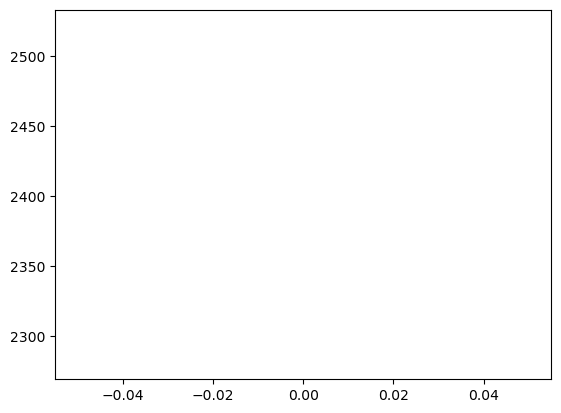

In [19]:
plt.plot(losses[-1])
losses[-1]

In [8]:
dcdxs = torch.zeros(12, 1)
dcdxs = torch.cat([dcdxs, dcdxs], dim = 0)
dcdxs

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])